# Validating Steane Encoding

In [3]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.visualization import plot_histogram 
import typing
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit_aer import Aer
from qiskit import transpile
from qiskit_aer.primitives import Sampler
from qiskit.primitives.backend_sampler import BackendSampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Instruction
from matplotlib import pyplot as plt
from qiskit.quantum_info import state_fidelity

First, we will validate the Steane encoding with the |0> state. There are two encoding schemes I use--the 7 qubit encoding scheme and the 8 qubit encoding scheme.


In [4]:


amp_0 = 1
amp_1 = 0

print(Statevector([amp_0, amp_1]))


Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


In [5]:
def steane_enc_8(amp_0: float, amp_1: float, is_ideal: bool):


    if is_ideal == True:
        steane_enc_block = QuantumCircuit(8, 8, name="steane_block")
    else:
        steane_enc_block = QuantumCircuit(8, name="steane_block_noise")


    steane_enc_block.h(0)
    steane_enc_block.h(4)
    steane_enc_block.h(6)

    #steane_enc_block.initialize([amp_0, amp_1], 6)
    steane_enc_block.initialize([amp_0, amp_1], 6)

    steane_enc_block.barrier()

    steane_enc_block.cx(0, 1)
    steane_enc_block.cx(4, 5)
    steane_enc_block.cx(6, 3)

    steane_enc_block.cx(4,2)
    steane_enc_block.cx(6,5)

    steane_enc_block.cx(0,3)
    steane_enc_block.cx(4,1)

    steane_enc_block.cx(3,2)

    steane_enc_block.cx(1,7)
    steane_enc_block.cx(3,7)
    steane_enc_block.cx(5,7)

    steane_enc_block.barrier()

    for i in range(0, 8):
        steane_enc_block.h(i)
        #steane_enc_block.measure(i,0)
    steane_enc_block.barrier()
    # steane_enc_block.measure(7,0)


    steane_enc_block.draw('mpl')

    return steane_enc_block

In [96]:
def steane_enc_7(amp_0: float, amp_1: float, is_ideal: bool):


    if is_ideal == True:
        steane_enc_block = QuantumCircuit(7, 7, name="steane_block")
    else:
        steane_enc_block = QuantumCircuit(7, name="steane_block_noise")

    for i in range(1,4):
        steane_enc_block.h(i)
    
    steane_enc_block.h(6)
    steane_enc_block.initialize([amp_0, amp_1], 6)

    steane_enc_block.barrier()

    steane_enc_block.cx(1,0)
    steane_enc_block.cx(2,4)
    steane_enc_block.cx(6,5)

    steane_enc_block.cx(2,0)
    steane_enc_block.cx(3,5)
    steane_enc_block.cx(6,4)
    steane_enc_block.cx(2,6)
    steane_enc_block.cx(3,4)
    steane_enc_block.cx(1,5)
    steane_enc_block.cx(1,6)
    steane_enc_block.cx(3,0)
    
    steane_enc_block.barrier()

    # switch to measuring in other basis
    for i in range(0, 7):
        steane_enc_block.h(i)

    #print(steane_enc_block)
    return steane_enc_block


steane_enc_7(amp_0, amp_1, True)

In [93]:
# convert to instruction
steane_block_instr = steane_enc_8(amp_0, amp_1, True).to_instruction()

In [94]:

steane_block_instr_7 = steane_enc_7(amp_0, amp_1, True).to_instruction()

                              ░ ┌───┐┌───┐                         ┌───┐ ░ »
q_0: ─────────────────────────░─┤ X ├┤ X ├─────────────────────────┤ X ├─░─»
     ┌───┐                    ░ └─┬─┘└─┬─┘                         └─┬─┘ ░ »
q_1: ┤ H ├────────────────────░───■────┼───────────────────■────■────┼───░─»
     ├───┤                    ░        │                   │    │    │   ░ »
q_2: ┤ H ├────────────────────░───■────■─────────■─────────┼────┼────┼───░─»
     ├───┤                    ░   │              │         │    │    │   ░ »
q_3: ┤ H ├────────────────────░───┼────■─────────┼────■────┼────┼────■───░─»
     └───┘                    ░ ┌─┴─┐  │  ┌───┐  │  ┌─┴─┐  │    │        ░ »
q_4: ─────────────────────────░─┤ X ├──┼──┤ X ├──┼──┤ X ├──┼────┼────────░─»
                              ░ ├───┤┌─┴─┐└─┬─┘  │  └───┘┌─┴─┐  │        ░ »
q_5: ─────────────────────────░─┤ X ├┤ X ├──┼────┼───────┤ X ├──┼────────░─»
     ┌───┐┌─────────────────┐ ░ └─┬─┘└───┘  │  ┌─┴─┐     └───┘┌─┴─┐      ░ »

In [7]:
steane_block_instr_noise = steane_enc_8(amp_0, amp_1, False).to_instruction()

In [124]:
steane_block_instr_7_noise = steane_enc_7(amp_0, amp_1, False).to_instruction()

In [8]:
# applies h to n qubits 
def create_h_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        h_block = QuantumCircuit(num, num, name="h_block")
    else:
        h_block = QuantumCircuit(num, name="h_block_noise")

    for i in range(0, num):
        h_block.h(i)

    # convert to instruction
    h_block_instr = h_block.to_instruction()
    return h_block_instr

In [9]:
# applies cz to n qubits
def create_cz_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        cz_block = QuantumCircuit(num*2, num*2, name="cz_block")
    else:
        cz_block = QuantumCircuit(num*2, name="cz_block_noise")
    
    for i in range(0, num):
        cz_block.cz(i, i + num)
        print(num)

    # convert to instruction
    cz_block_instr = cz_block.to_instruction()
    return cz_block_instr

In [10]:
# applies identity to 7 qubits
def create_id_block(num: int, is_ideal: bool):

    if (is_ideal == 1):
        id_block = QuantumCircuit(num, num, name = "id_block")
    else:
        id_block = QuantumCircuit(num, name = "id_block")
    

    for i in range(0, num):
        id_block.id(i)

    id_block_instr = id_block.to_instruction()
    return id_block_instr

In [11]:
# applies x to 7 qubits
def create_x_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        x_block = QuantumCircuit(num, num, name = "x_block")
    else:
        x_block = QuantumCircuit(num, name = "x_block")
    

    for i in range(0, num):
        x_block.x(i)

    x_block_instr = x_block.to_instruction()
    return x_block_instr

In [12]:
def prepare_state(qc_prep: QuantumCircuit, encode_block: Instruction, log_block: Instruction, num: int, is_ideal: bool):

    if (is_ideal == 1):
        qc_prep.append(create_id_block(num, is_ideal), range(0,num), range(0,num))
        qc_prep.append(encode_block, range(0,num), range(0,num))
        qc_prep.append(create_id_block(num, is_ideal), range(0,num), range(0,num))
        qc_prep.append(log_block,range(0,num), range(0,num))
        qc_prep.draw('mpl')
    else:
        qc_prep.append(create_id_block(num, is_ideal), range(0,num))
        qc_prep.append(encode_block, range(0,num))
        qc_prep.append(create_id_block(num, is_ideal), range(0,num))
        qc_prep.append(log_block,range(0,num))
        qc_prep.draw('mpl')



In [40]:


qca = QuantumCircuit(8,8)
qcb = QuantumCircuit(8,8)
qcc = QuantumCircuit(8,8)

qc_arr_meas = [qca, qcb, qcc]


def preparation_results(qc_arr: list, num: int, is_ideal: bool, is_counts:bool, encoding: Instruction, noise_model: NoiseModel):



    state_arr = []
    counts_arr = []

    

    
    for i in range(0,3): 

        prepare_state(qc_arr[i], encoding, create_id_block(num, is_ideal), num, is_ideal)

        for j in range(0,num):
            qc_arr[i].measure(j,j)

        if is_counts == False:
            simulator = Aer.get_backend('statevector_simulator')
            steane_t = transpile(qc_arr[i], simulator)
            job = simulator.run(steane_t, shots = 1000)
            result = job.result()
            counts = result.get_counts()
            state = result.get_statevector()
            state_arr.append(state)
            counts_arr.append(counts)
        else:
            backend = AerSimulator(noise_model=noise_model)
            transpiled = transpile(qc_arr[i], backend)
            job = backend.run(transpiled, shots = 1000)
            result = job.result()
            counts_n = result.get_counts()
            counts_arr.append(counts_n)

    return [state_arr, counts_arr]


        
    




In [41]:
no_noise = NoiseModel()

In [42]:
[state_arr_meas, counts_arr_meas] = preparation_results(qc_arr_meas, 8, True, True, steane_block_instr, no_noise)

In [99]:
qcx = QuantumCircuit(7,7)
qcy = QuantumCircuit(7,7)
qcz = QuantumCircuit(7,7)

qc_arr_meas_7 = [qcx, qcy, qcz]

[state_arr_meas_7, counts_arr_meas_7] = preparation_results(qc_arr_meas_7, 7, True, True, steane_block_instr_7, no_noise)


c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


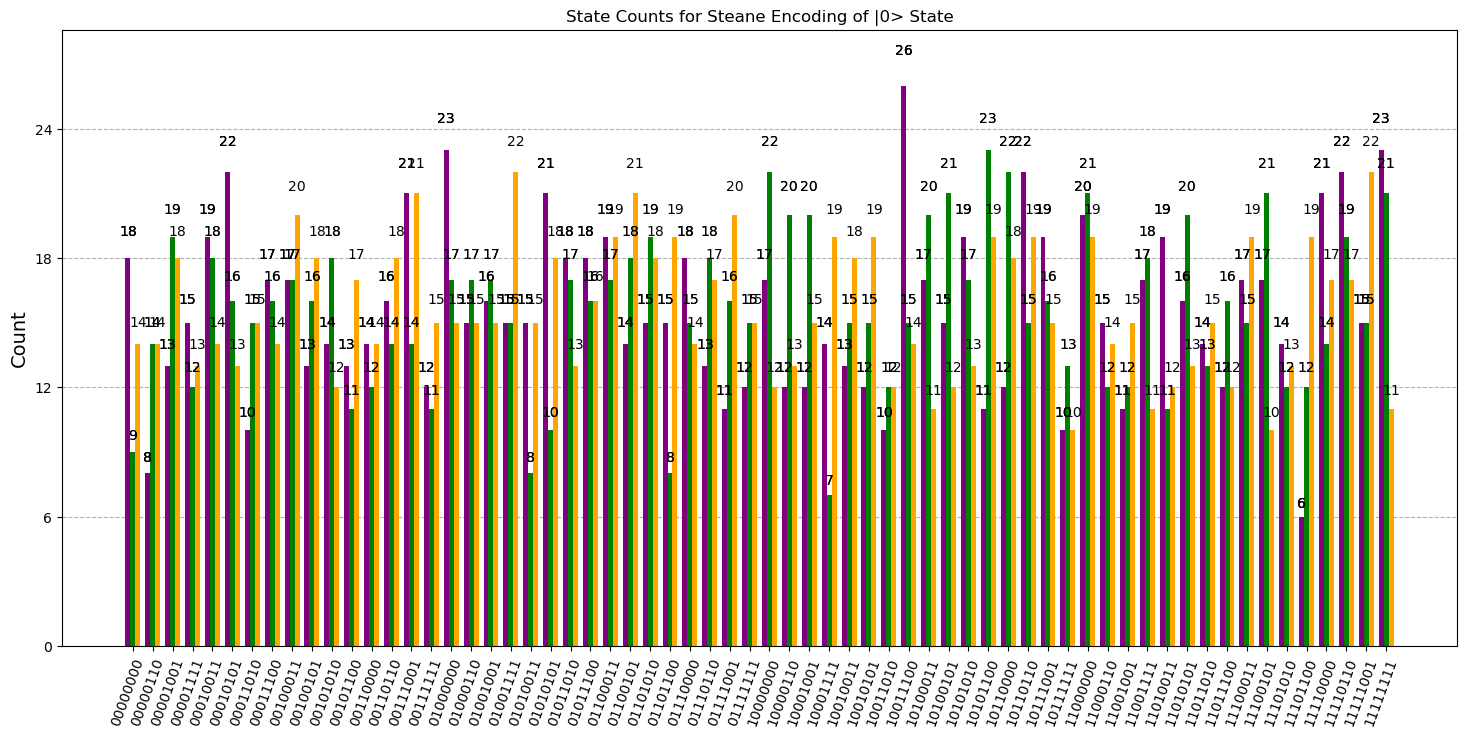

In [43]:
plot_histogram(counts_arr_meas, 
               figsize = (18, 8), 
               title = "State Counts for Steane Encoding of |0> State",
               color = ["purple", "green", "orange"])

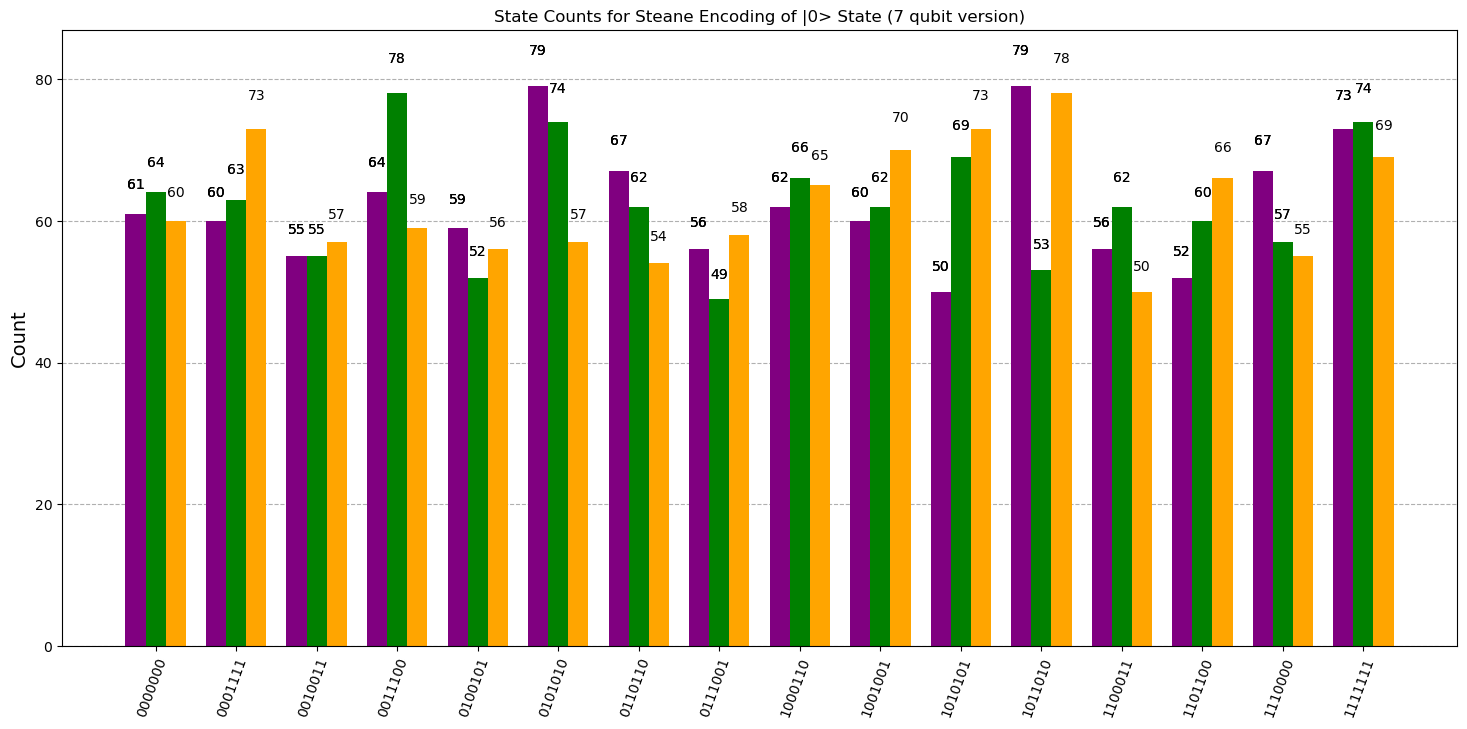

In [100]:
plot_histogram(counts_arr_meas_7, 
               figsize = (18, 8), 
               title = "State Counts for Steane Encoding of |0> State (7 qubit version)",
               color = ["purple", "green", "orange"])

In [116]:
def raw_v_enc(raw_sv: Statevector, state_arr_sv: list):
    fid_arr = []
    err_arr = []
    for z in state_arr_sv[0]:
        state = np.array([np.sqrt(1 - abs(z)**2), z], dtype=np.complex128)
        svi = Statevector(state)
        fid = state_fidelity(raw_sv, svi)
        #print(fid)
        err = 1 - fid
        fid_arr.append(fid)
        err_arr.append(err)

    # print([np.sqrt(1 - abs(z)**2), z])

    mean_err = np.mean(err_arr)
    mean_fid = np.mean(fid_arr)

    # print(err_arr)
    # print(fid_arr)

    return [err_arr, fid_arr, mean_err, mean_fid]


    
    

In [ ]:

state_arr = []

qca = QuantumCircuit(8,8)
qcb = QuantumCircuit(8,8)
qcc = QuantumCircuit(8,8)

qc_arr = [qca, qcb, qcc]
counts_arr = []
is_ideal = 1

[state_arr_sv, counts_arr_sv] = preparation_results(qc_arr, 8, True, False, steane_block_instr, no_noise)


qcx = QuantumCircuit(7,7)
qcy = QuantumCircuit(7,7)
qcz = QuantumCircuit(7,7)

qc_arr_7 = [qcx, qcy, qcz]


[state_arr_sv_7, counts_arr_sv_7] = preparation_results(qc_arr_7, 7, True, False, steane_block_instr_7, no_noise)


    







c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
0.00390625
0.0078125


C:\Users\diyan\AppData\Local\Temp\ipykernel_13808\4282481916.py:4: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for z in state_arr_sv[0]:


### Mean Error and Mean Fidelity of Raw vs. Steane Encoded |0>


In [117]:
# Compare ideal raw state to encoded state

sv = Statevector([amp_0, amp_1])
print(sv)

[err_8_arr, fid_8_arr, err_8_mean, fid_8_mean] = raw_v_enc(sv, state_arr_sv)
[err_7_arr, fid_7_arr, err_7_mean, fid_7_mean]  = raw_v_enc(sv, state_arr_sv_7)

print(err_8_mean)
print(err_7_mean)

Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
0.00390625
0.0078125


C:\Users\diyan\AppData\Local\Temp\ipykernel_13808\3768237828.py:4: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for z in state_arr_sv[0]:


In [113]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Fidelity Errors Preparing |0> State in the Steane Code')

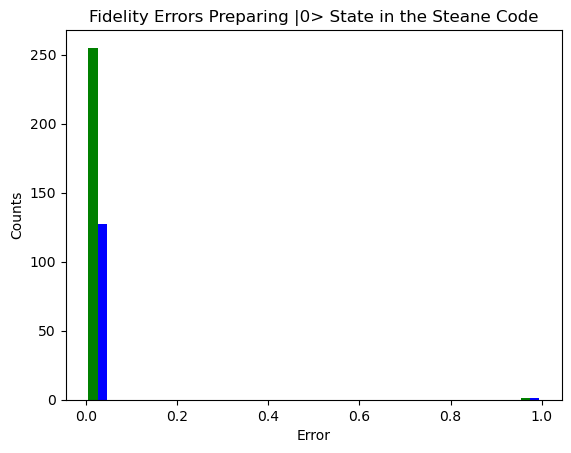

In [118]:

plt.hist([err_8_arr, err_7_arr], bins = 20, color= ['green', 'blue'])
plt.xlabel("Error")
plt.ylabel("Counts")
plt.title("Fidelity Errors Preparing |0> State in the Steane Code")

The mean error rate for 8 qubit encoding scheme is 0.39%, while the mean error rate for 7 qubit encoding is 0.78%

In [48]:
from qiskit.quantum_info import DensityMatrix

In [119]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cz'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cx'])

# 5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.95, 0.05],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.05, 0.95]]) # P(0 | 1), P(1 | 1)

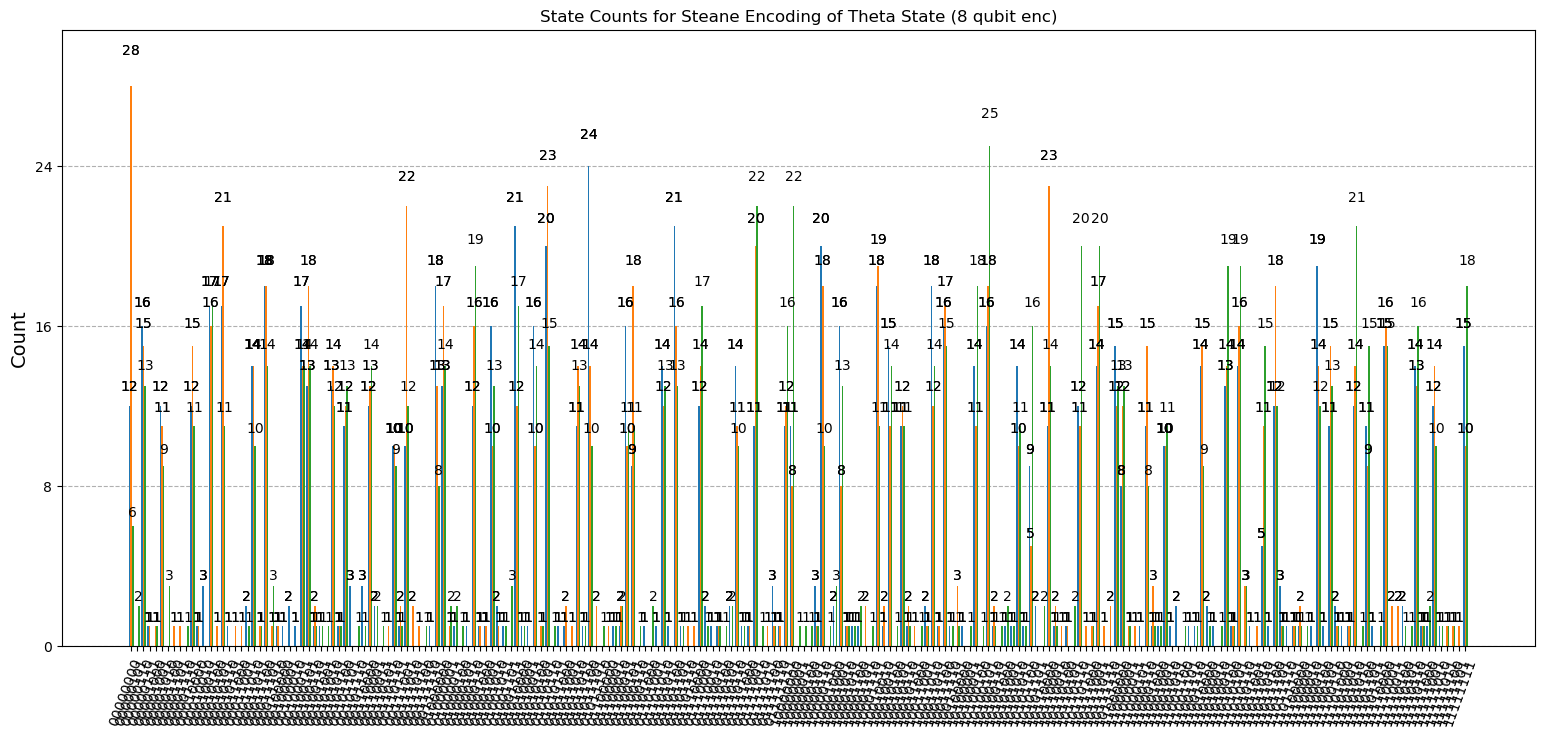

In [126]:


state_arr_n = []

qca_n = QuantumCircuit(8,8)
qcb_n = QuantumCircuit(8,8)
qcc_n = QuantumCircuit(8,8)

qc_arr_n = [qca_n, qcb_n, qcc_n]

[state_arr_n, counts_arr_n] = preparation_results(qc_arr_n, 8, False, True, steane_block_instr_noise, noise_model)



plot_histogram(counts_arr_n, figsize = (19, 8), title = "State Counts for Steane Encoding of Theta State (8 qubit enc)")




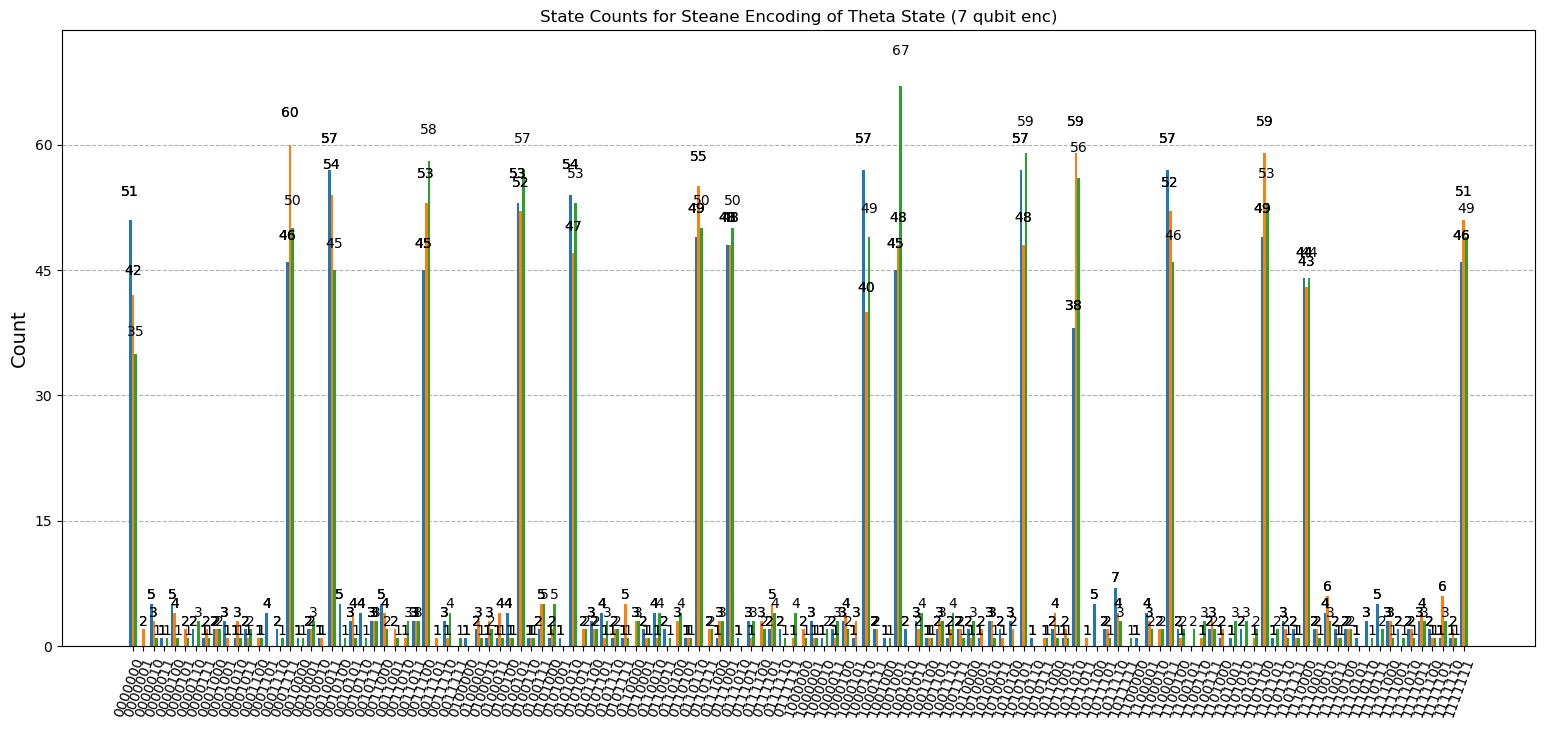

In [127]:
qcx_n = QuantumCircuit(7,7)
qcy_n = QuantumCircuit(7,7)
qcz_n = QuantumCircuit(7,7)

qc_arr_n_7 = [qcx_n, qcy_n, qcz_n]

[state_arr_n_7, counts_arr_n_7] = preparation_results(qc_arr_n_7, 7, False, True, steane_block_instr_7_noise, noise_model)


plot_histogram(counts_arr_n_7, figsize = (19, 8), title = "State Counts for Steane Encoding of Theta State (7 qubit enc)")

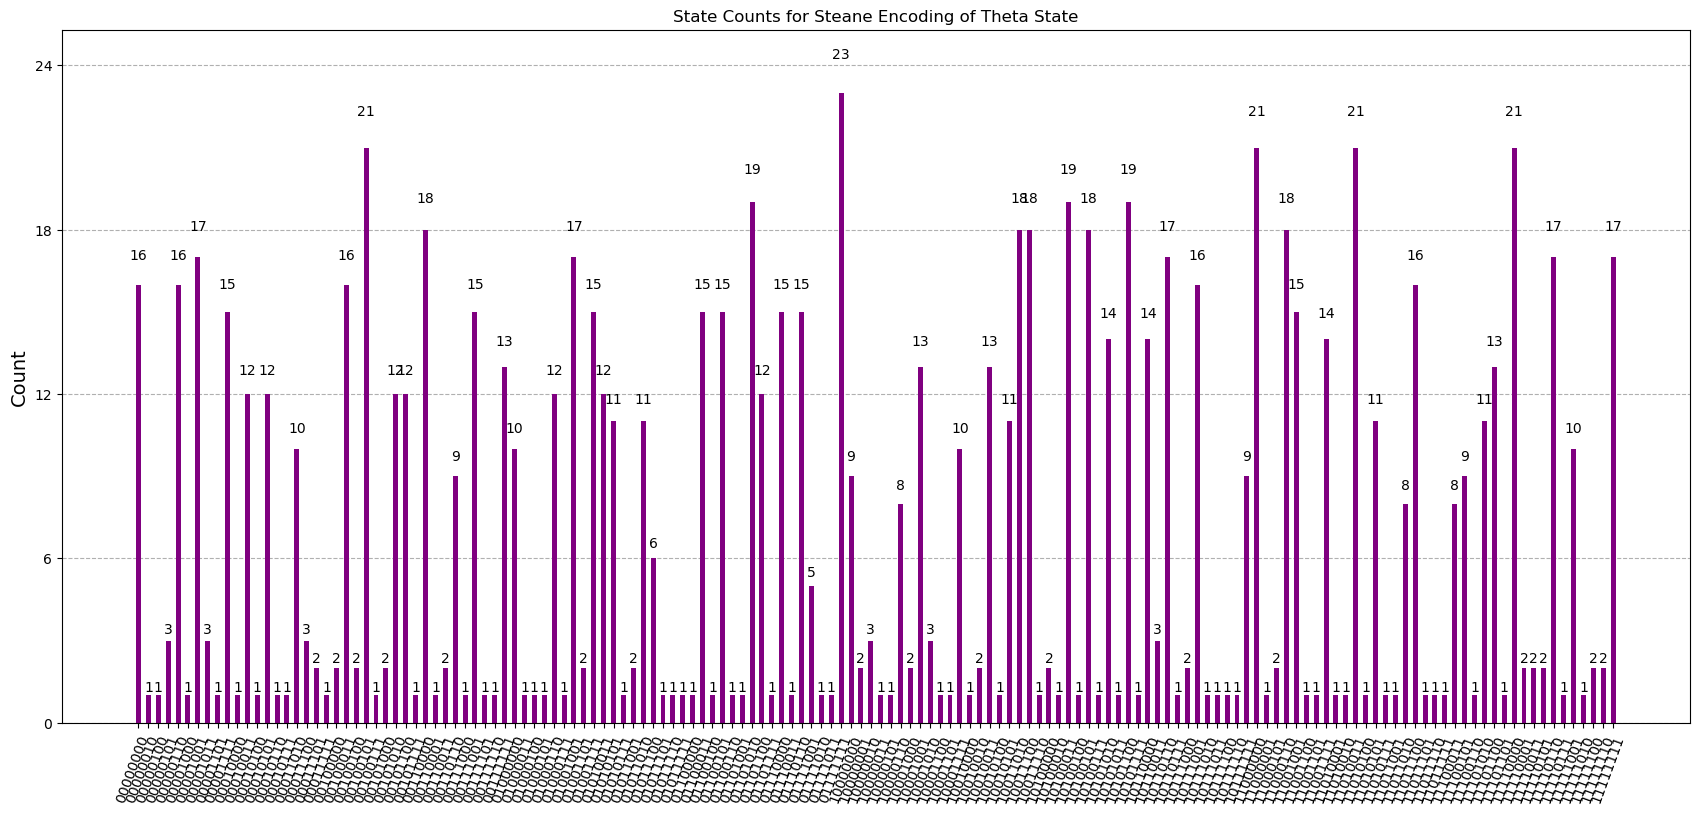

In [52]:
plot_histogram(counts_arr_n[0], 
               figsize = (21, 9), 
               title = "State Counts for Steane Encoding of Theta State",
               color = "purple")


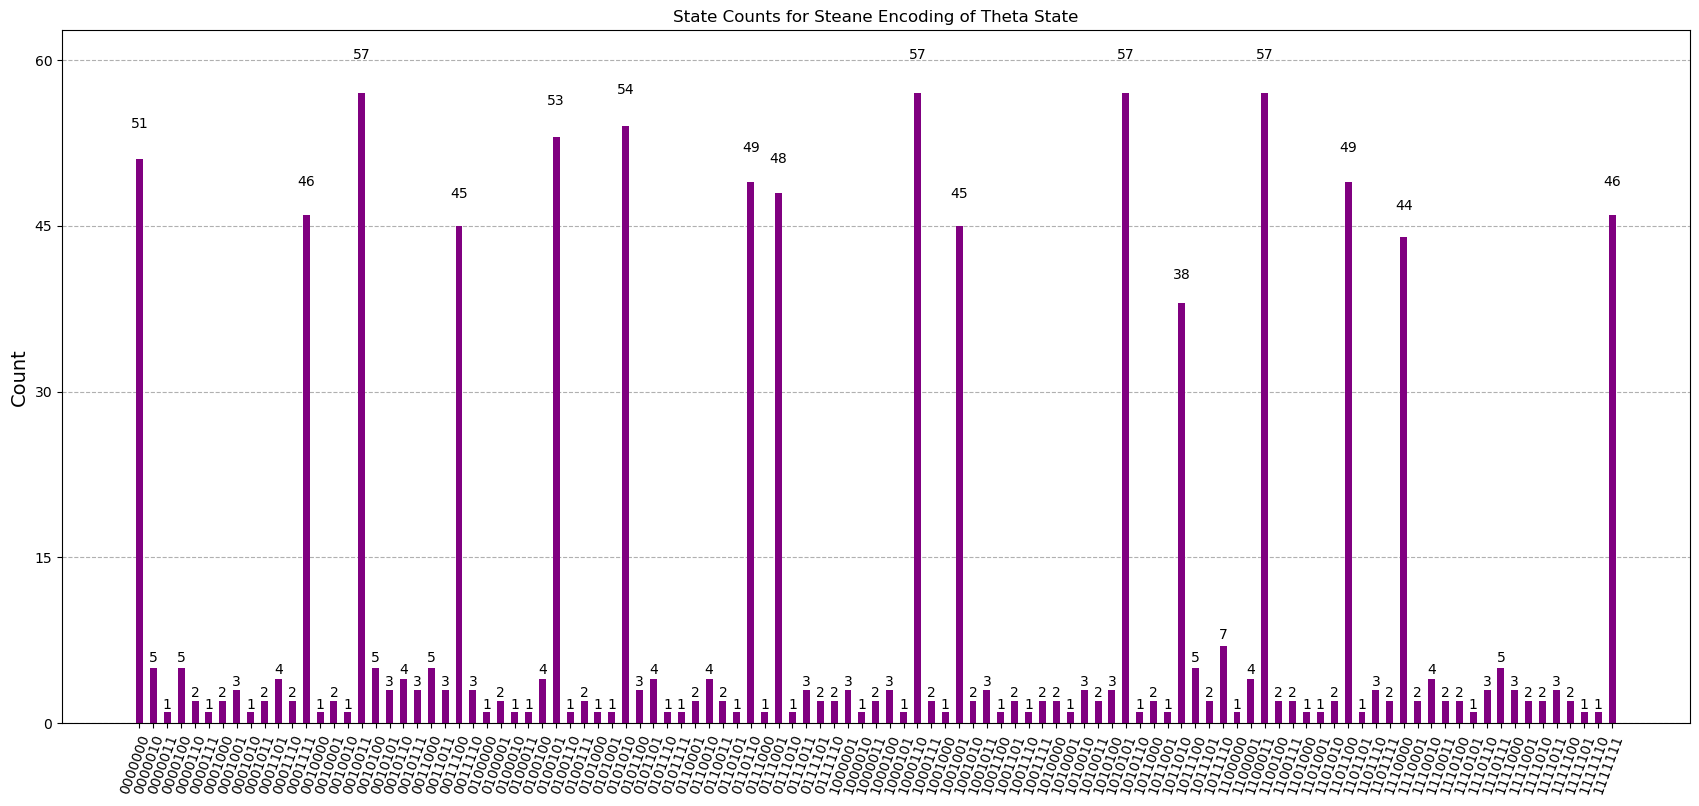

In [128]:
plot_histogram(counts_arr_n_7[0], 
               figsize = (21, 9), 
               title = "State Counts for Steane Encoding of Theta State",
               color = "purple")

In [32]:
# plt.hist(err_arr, bins = 20, color= 'red')
# plt.xlabel("Error")
# plt.ylabel("Counts")
# plt.title("Fidelity Errors Preparing Theta State in the Steane Code")

In [53]:
from collections import defaultdict
import numpy as np

def fidelity_from_counts(counts_ideal, counts_noisy):
    # Normalize to probabilities
    total_ideal = sum(counts_ideal.values())
    total_noisy = sum(counts_noisy.values())

    p = defaultdict(float, {k: v / total_ideal for k, v in counts_ideal.items()})
    q = defaultdict(float, {k: v / total_noisy for k, v in counts_noisy.items()})

    # Get all keys
    all_keys = set(p) | set(q)

    # Bhattacharyya coefficient
    bc = sum(np.sqrt(p[k] * q[k]) for k in all_keys)
    return bc ** 2  # fidelity minimum bound

## Fidelity of |0>

In [131]:

mean_arr_fid = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_meas[i], counts_arr_n[i])
    mean_arr_fid.append(ffc)


print(mean_arr_fid)
print(np.mean(mean_arr_fid))



[0.8645146816461987, 0.8733620944561017, 0.8607557789579663]
0.8662108516867555


In [133]:
mean_arr_fid_7 = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_meas_7[i], counts_arr_n_7[i])
    mean_arr_fid_7.append(ffc)


print(mean_arr_fid_7)
print(np.mean(mean_arr_fid_7))


[0.7870359637365988, 0.803910546779237, 0.8167447167628668]
0.8025637424262341


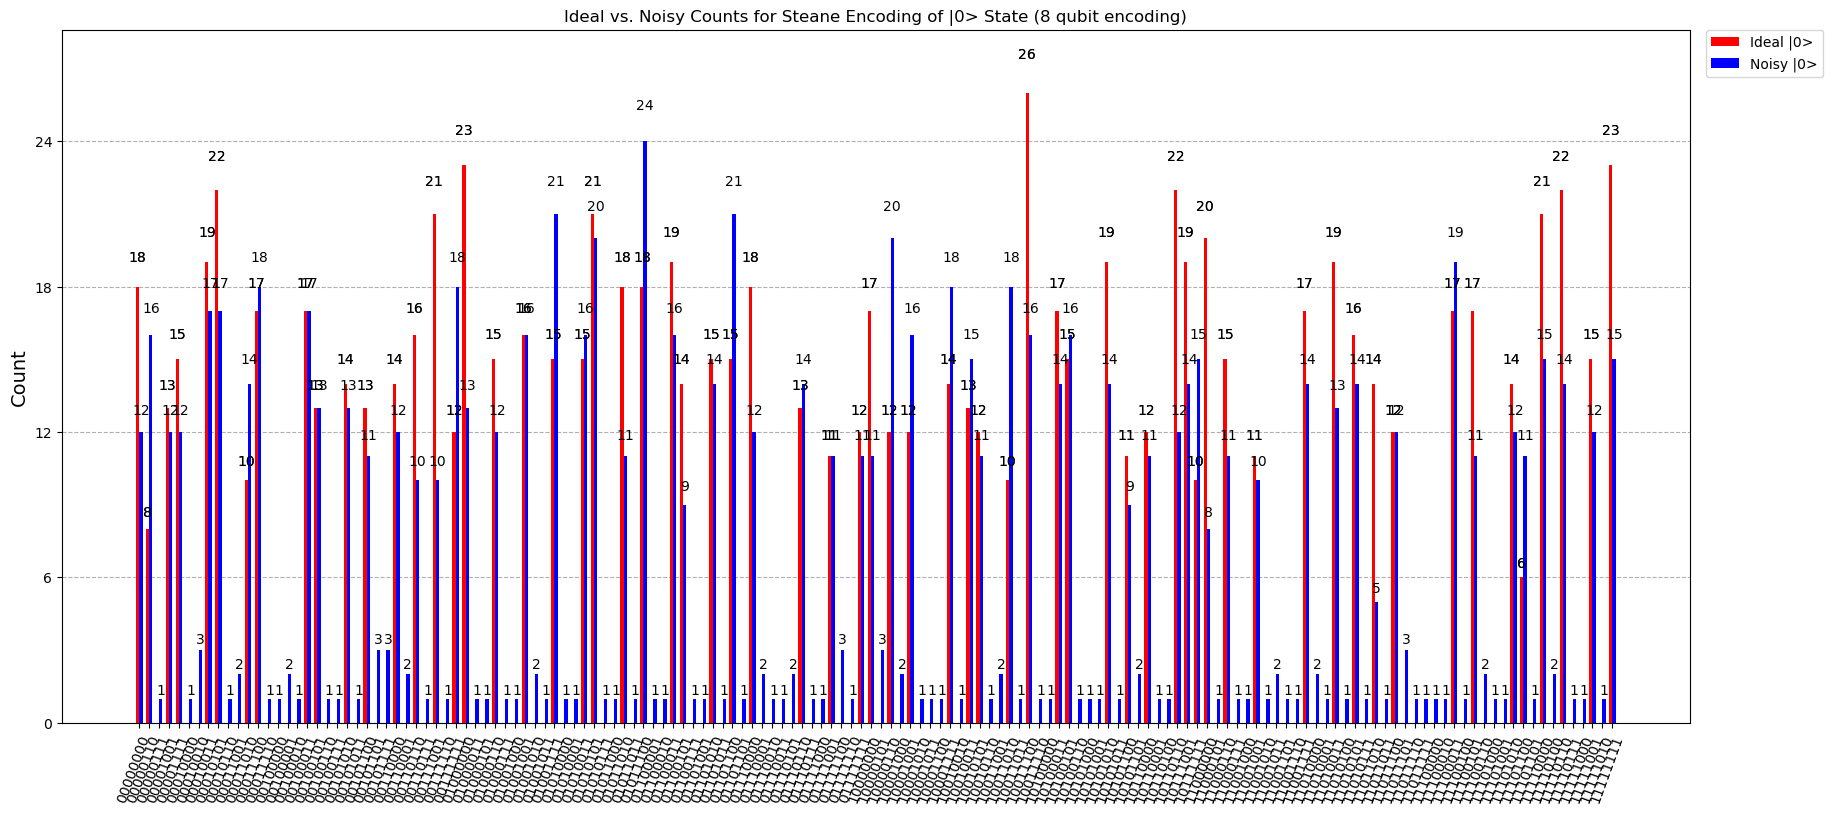

In [135]:
plot_histogram([counts_arr_meas[0], counts_arr_n[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for Steane Encoding of |0> State (8 qubit encoding)", 
               bar_labels = True, 
               legend=['Ideal |0>', 'Noisy |0>'],
               color = ["red", "blue"])

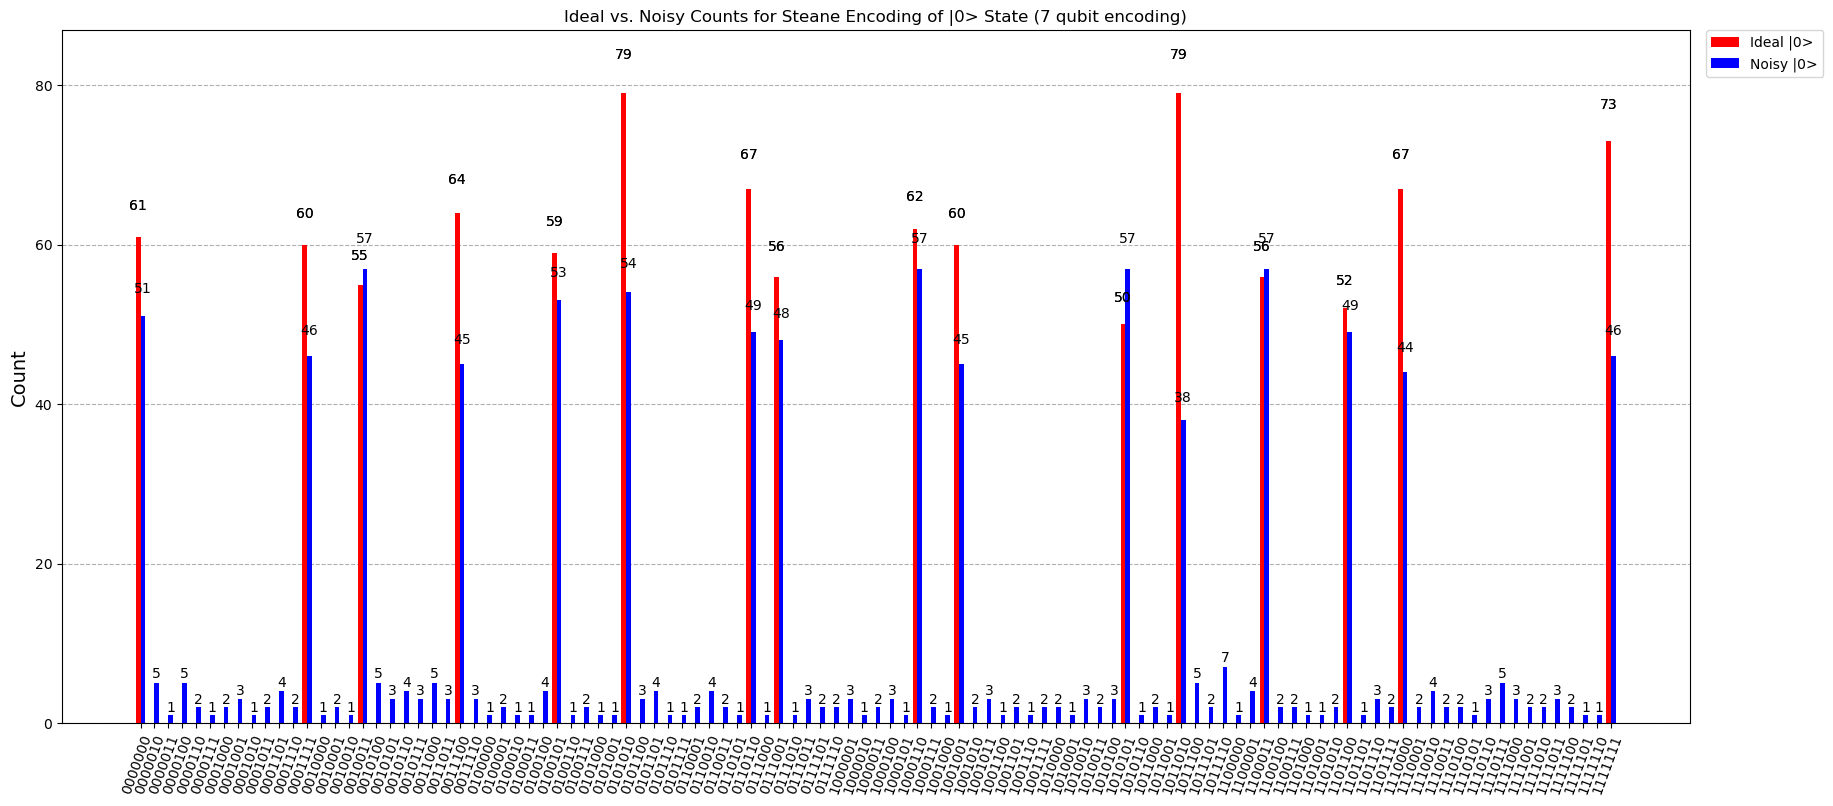

In [136]:
plot_histogram([counts_arr_meas_7[0], counts_arr_n_7[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for Steane Encoding of |0> State (7 qubit encoding)", 
               bar_labels = True, 
               legend=['Ideal |0>', 'Noisy |0>'],
               color = ["red", "blue"])

# Testing Theta state

Now we test the theta state! We should obtain a similar fidelity

In [137]:

theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0_theta = np.cos(theta/2)
amp_1_theta = np.sin(theta/2)

print(Statevector([amp_0_theta, amp_1_theta]))

steane_intr_theta_ideal = steane_enc_8(amp_0_theta, amp_1_theta, True)
steane_intr_theta_ideal_7 = steane_enc_7(amp_0_theta, amp_1_theta, True)

Statevector([0.94502682+0.j, 0.32699283+0.j],
            dims=(2,))


In [ ]:
qcx_n = QuantumCircuit(7,7)
qcy_n = QuantumCircuit(7,7)
qcz_n = QuantumCircuit(7,7)

qc_arr_n_7 = [qcx_n, qcy_n, qcz_n]

[state_arr_theta_ideal, counts_arr_theta_ideal] = preparation_results(qc_arr_theta, 8, True, True, steane_block_instr, no_noise)
    



c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


In [ ]:
state_arr_theta = []

qca = QuantumCircuit(8,8)
qcb = QuantumCircuit(8,8)
qcc = QuantumCircuit(8,8)

qc_arr_theta = [qca, qcb, qcc]

[state_arr_theta_ideal, counts_arr_theta_ideal] = preparation_results(qc_arr_theta, 8, True, True, steane_block_instr, no_noise)

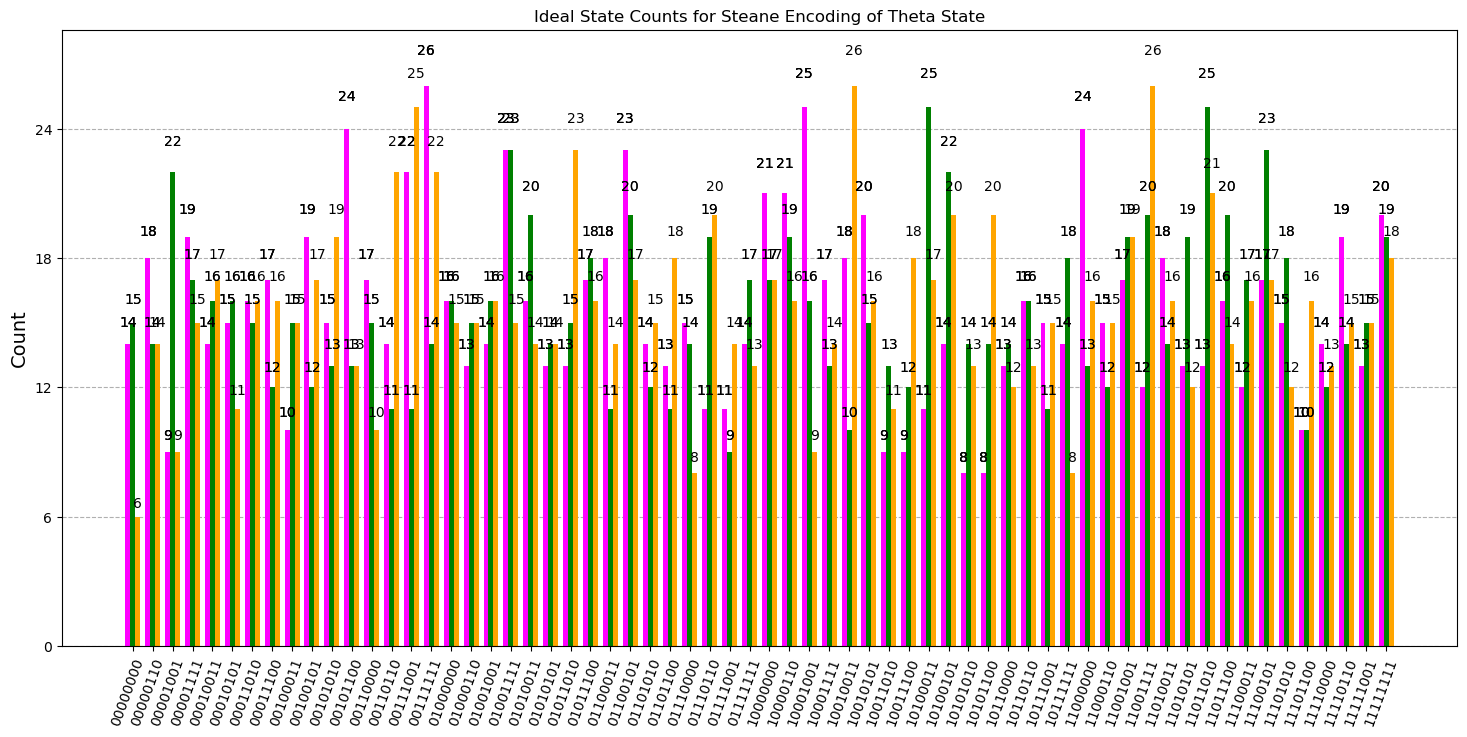

In [66]:
plot_histogram(counts_arr_theta_ideal, 
               figsize = (18, 8), 
               title = "Ideal State Counts for Steane Encoding of Theta State",
               color = ["magenta", "green", "orange"])

In [67]:


state_arr_theta_n = []

qca_n = QuantumCircuit(8,8)
qcb_n = QuantumCircuit(8,8)
qcc_n = QuantumCircuit(8,8)

qc_arr_theta_n = [qca_n, qcb_n, qcc_n]




[state_arr_theta_n, counts_arr_theta_n] = preparation_results(qc_arr_theta_n, 8, False, True, steane_block_instr_noise, noise_model)






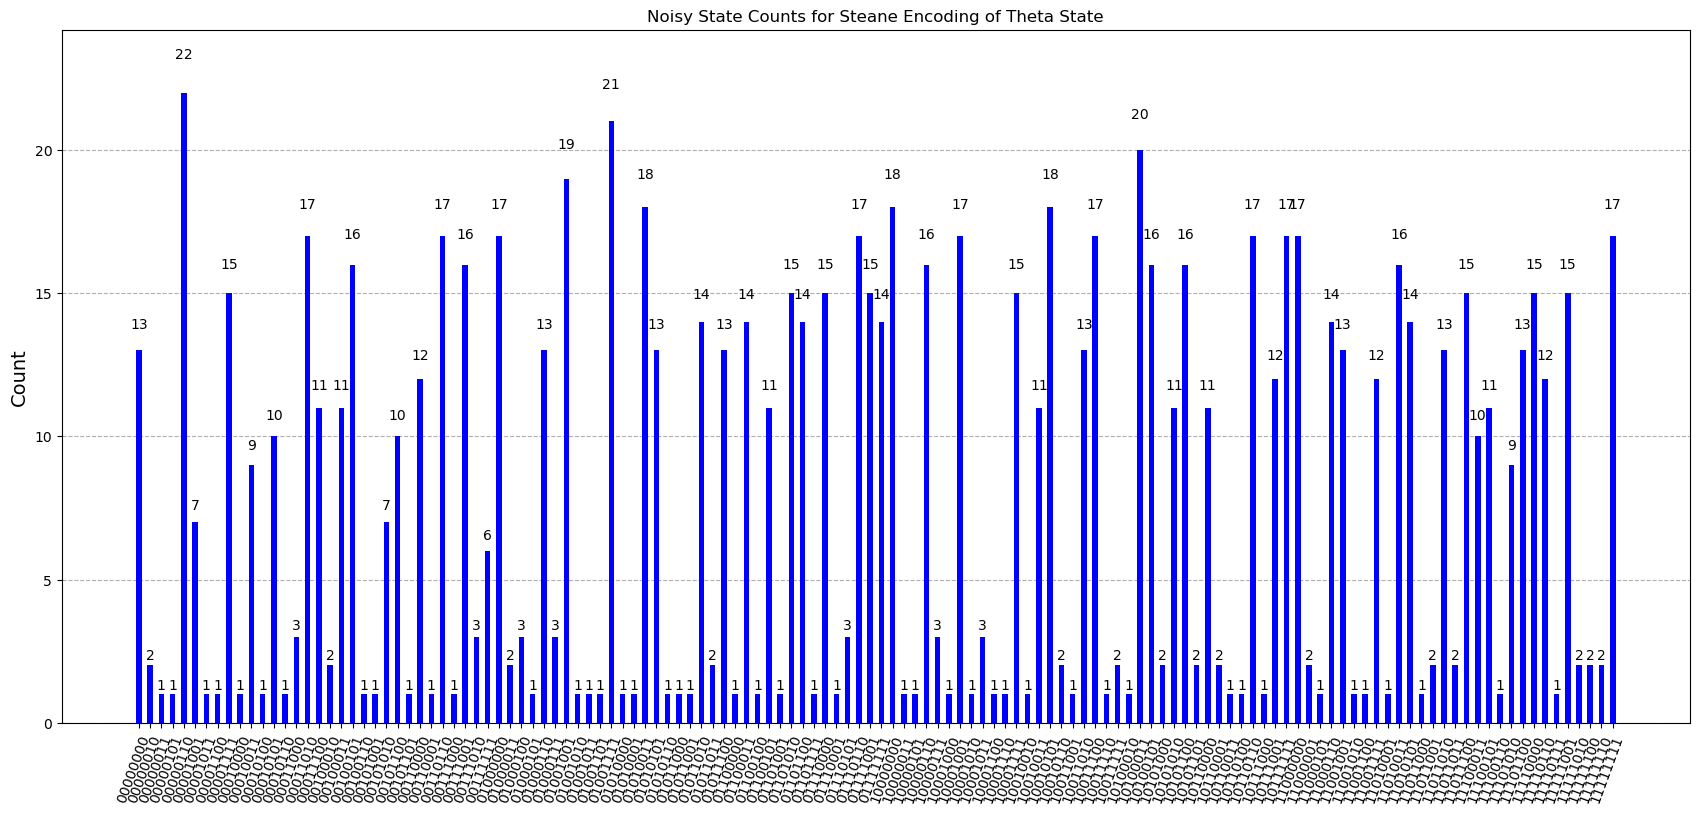

In [68]:
plot_histogram(counts_arr_theta_n[0], 
               figsize = (21, 9), 
               title = "Noisy State Counts for Steane Encoding of Theta State", 
               bar_labels = True,
               color = "blue")

## Fidelity of Theta State

In [70]:
mean_arr_theta_fid = []
err_arr_theta = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_theta_ideal[i], counts_arr_theta_n[i])
    mean_arr_theta_fid.append(ffc)
    err_arr_theta.append(1 - ffc)



print(mean_arr_theta_fid)
print(np.mean(mean_arr_theta_fid))

[0.8768307487083246, 0.8711532621409137, 0.8669951405123089]
0.8716597171205157


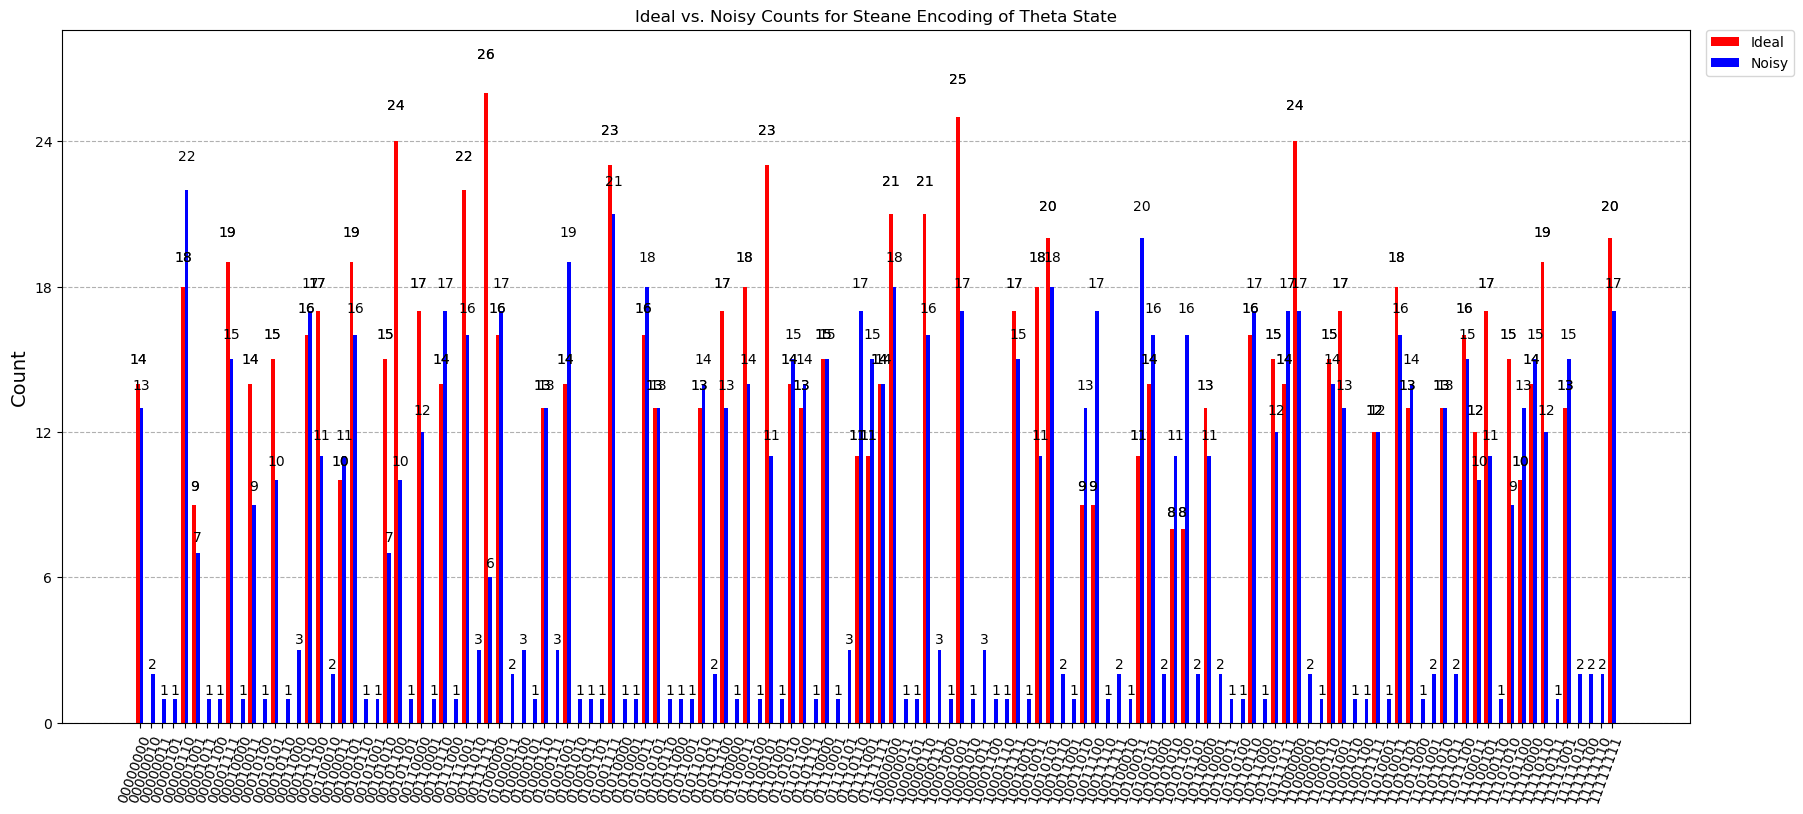

In [72]:
plot_histogram([counts_arr_theta_ideal[0], counts_arr_theta_n[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for Steane Encoding of Theta State", 
               bar_labels = True, 
               legend=['Ideal', 'Noisy'],
               color = ["red", "blue"])

